# Machine Learning on Histopathological Dataset for Breast Cancer
Dataset from [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

In [0]:
from keras import backend as K
K.load_backend

Using TensorFlow backend.


<module 'keras.backend.load_backend' from '/usr/local/lib/python3.6/dist-packages/keras/backend/load_backend.py'>

## Getting dataset from google drive


Uploaded dataset at [Google Drive](https://drive.google.com/drive/folders/1UKu3laj09vtjaS203w71pvWkUHF_SjIo?usp=sharing)

### Mounting Google drive

In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Extracting data from drive

In [0]:
import zipfile

zip_dir = '/content/drive/My Drive/Datasets/histopathologic-cancer-detection.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/tmp/histo/')
zip_ref.close()

### Rearranging data and directories


In [0]:
train_zip_dir = '/tmp/histo/train.zip'
test_zip_dir = '/tmp/histo/test.zip'

train_zip_ref = zipfile.ZipFile(train_zip_dir, 'r')
train_zip_ref.extractall('/tmp/histo/train/')
train_zip_ref.close()

test_zip_ref = zipfile.ZipFile(test_zip_dir, 'r')
test_zip_ref.extractall('/tmp/histo/test/')
test_zip_ref.close()

In [0]:
!rm /tmp/histo/test.zip
!rm /tmp/histo/train.zip

Read the tabel of labelled filenames

In [0]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format

histo_dataframe = pd.read_csv('/tmp/histo/train_labels.csv')

histo_dataframe = histo_dataframe.reindex(
    np.random.permutation(histo_dataframe.index))
histo_dataframe

,id,label
60488,2305cf11b0ea881a8a5f5346fcf9c2bc8cb2e205,1
30991,d6a4fc7dae59fa45e350487edb9f587804c7edcf,0
8104,dcff49b34482ba7d0cfb113b0cf817b765ac9901,0
205529,efc95aa3af2a03871f74f614abbec8ccb0e5ecfa,1
18835,1258f0edd6faa26dc8e31da553890ca83fd1fa76,0
...,...,...
166292,08dc391219748d52490b826b4560519f0267cd80,0
85325,7e356984f9a90764d975ded1b7cc73dd6fa40cea,1
20859,9c67a6d31566915675040e858a95654e13baa0ef,1
16462,c155454210f96222e0c50570042587533ed1f626,0


Getting split lengths for training data for 70-30 train-val splits

In [0]:
train_percentage = 70.0
total_len = len(histo_dataframe)
train_len = int(total_len * 0.7)
val_len = total_len - train_len

In [0]:
train_benign_names = list()
train_malignant_names = list()
for i in histo_dataframe.head(train_len).index:
  if (histo_dataframe['label'][i] == 0):
    train_benign_names.append(histo_dataframe['id'][i] + ".tif")
  else: 
    train_malignant_names.append(histo_dataframe['id'][i] + ".tif")


val_benign_names = list()
val_malignant_names = list()
for i in histo_dataframe.tail(val_len).index:
  if (histo_dataframe['label'][i] == 0):
    val_benign_names.append(histo_dataframe['id'][i] + ".tif")
  else: 
    val_malignant_names.append(histo_dataframe['id'][i] + ".tif")

move around the files in the right order

In [0]:
!mkdir /tmp/histo/train/train/
!mkdir /tmp/histo/train/train/benign/
!mkdir /tmp/histo/train/train/malignant/

!mkdir /tmp/histo/train/val/
!mkdir /tmp/histo/train/val/benign/
!mkdir /tmp/histo/train/val/malignant/

move data from extracted directory into designated directories

In [0]:
import os

base_dir = '/tmp/histo/train'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

train_benign_dir = os.path.join(train_dir, 'benign')
train_malignant_dir = os.path.join(train_dir, 'malignant')

val_benign_dir = os.path.join(val_dir, 'benign')
val_malignant_dir = os.path.join(val_dir, 'malignant')

for fname in train_benign_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(train_benign_dir, fname))

for fname in train_malignant_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(train_malignant_dir, fname))

for fname in val_benign_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(val_benign_dir, fname))

for fname in val_malignant_names:
  os.rename(os.path.join(base_dir, fname), os.path.join(val_malignant_dir, fname))

## Displaying some slices

Benign


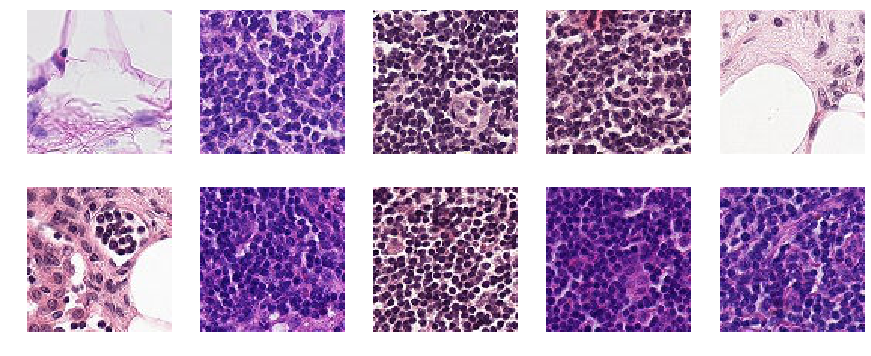

Malignant


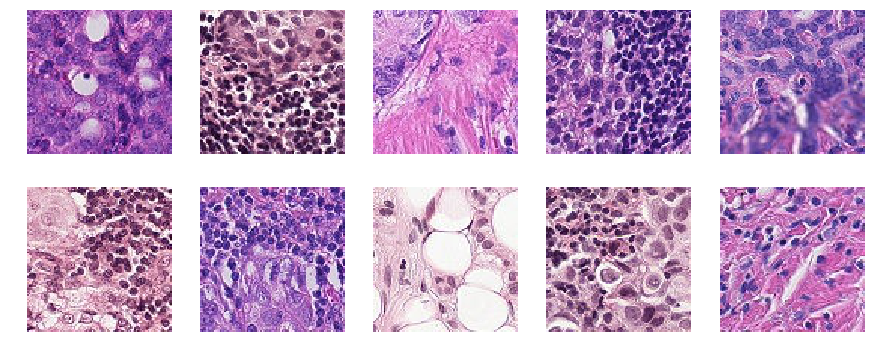

In [0]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

images_per_class = 10

print("Benign")

plt.figure(figsize=(15,6))
for i in range(1, images_per_class + 1):
  plt.subplot(2, 5, i)
  plt.axis('off')
  selected_img = np.random.choice(os.listdir(val_benign_dir))
  plt.imshow(mpimg.imread(os.path.join(val_benign_dir, selected_img)))

plt.show()
print("Malignant")

plt.figure(figsize=(15,6))
for i in range(1, images_per_class + 1):
  plt.subplot(2, 5, i)
  plt.axis('off')
  selected_img = np.random.choice(os.listdir(val_malignant_dir))
  plt.imshow(mpimg.imread(os.path.join(val_malignant_dir, selected_img)))

## Preprocessing and Loading data

Creating data generators for easy augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Add augmentation over here
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 30

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary')



Found 154017 images belonging to 2 classes.
Found 66008 images belonging to 2 classes.


In [0]:
def get_training_metrics(train_split_percentage, history, optimizer,learning_rate, steps_per_epoch, total_epochs, validation_steps, batch_size, verbose=True, add_table_header = False, frozen_layer=None):
  """Gets the model metrics in a documentable format
  Args:
    train_split_percentage: `int` for the percentage of the dataset allocated to print
    model: `Model` object containing the trained model
    history: `History` object containing the training history
    optimzer: `optimizer` object for tensorflow used for optimization during training
    learning_rate: `float` for the learning rate
    steps_per_epoch: `int` for batches tried per one epoch
    total_epochs: `int` for total number of epochs
    batch_size: `int` for the images per batch
    verbose: `bool` indicating to not only return, but to print
    add_table_header: `bool` indicating whether to print values along with the table header
    frozen_layer: `string` containing name of layer used as last layer in freature extraction
  Returns:
    A string containing the tabular metrics
  """
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  optimizer_name = 'SGD'
  if(verbose):
    print("copy the following text to your notebook text block: ")

  output_str = ""
  if(add_table_header):
    output_str += ">"
    if (frozen_layer):
      output_str += "Last Layer | "
    output_str += "Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate\n"
    output_str += ">"
    if (frozen_layer):
      output_str += "--- | "
    output_str += "--- | --- | --- | --- | --- | --- | ---\n"

  output_str += "> " 
  if (frozen_layer):
    output_str += frozen_layer + " | "
  output_str += "%02d-%02d | %02d | %02d | %02d | %02d | %s | %f \n" % (int(train_split_percentage), (100 - int(train_split_percentage)),
         batch_size,
         total_epochs,
         steps_per_epoch,
         validation_steps,
         optimizer_name,
         learning_rate)
  
  
  output_str += ">$Loss_{train} =  %.4f$ | | $Loss_{val} = %.4f$ |  |$Accuracy_{train} = %.4f$ | |  $Accuracy_{val} = %.4f$\n" % (loss[-1], 
         val_loss[-1], 
         acc[-1], 
         val_acc[-1])
  if(verbose):
    print(output_str)
  return output_str
  

In [0]:
test_string = "hello %i" % (12)
print(test_string)

hello 12


In [0]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, label="Training")
  plt.plot(epochs, val_acc, label="Validation")
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label="Training")
  plt.plot(epochs, val_loss, label="Validation")
  plt.title('Training and validation loss')
  plt.legend()


In [0]:
from keras import layers
from keras import Model
from keras.optimizers import Adagrad, SGD

# Standard (In Progress: Model tweaking)

## Building and compiling the architecture

In [0]:
img_input = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)

standard_model = Model(img_input, output)

standard_model.summary()

## Fitting data on the model

Fitting trials on rough CNN architecture: 

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 500 | 100 | Adagrad | 0.0001
>$Loss_{train} =  0.529$ | | $Loss_{val} = 8.325$ |  |$Accuracy_{train} = 0.741$ | |  $Accuracy_{val} = 0.456$
>70-30 | 30 | 30 | 500 | 250 | Adagrad | 0.0001
>$Loss_{train} =  0.546$ | | $Loss_{val} = 0.533$ |  |$Accuracy_{train} = 0.745$ | |  $Accuracy_{val} = 0.744$
>70-30 | 100 | 30 | 1600 | 250 | SGD | 0.0001
>$Loss_{train} =  9.1188$ | | $Loss_{val} = 0.4053$ |  |$Accuracy_{train} = 9.1340$ | |  $Accuracy_{val} = 0.4043$
>70-30 | 100 | 15 | 100 | 250 | ? | ? 
>$Loss_{train} =  0.629$ | | $Loss_{val} = 0.614$ |  |$Accuracy_{train} = 0.646$ | |  $Accuracy_{val} = 0.663$
>70-30 | 100 | E=20 | 100 | 600 | SGD | 0.0005
>$Loss_{train} =  0.554$ | | $Loss_{val} = 0.537$ |  |$Accuracy_{train} = 0.729$ | |  $Accuracy_{val} = 0.752$
>70-30 | 100 | 30 | 100 | 600 | SGD | 0.0001
>$Loss_{train} =  0.622$ | | $Loss_{val} = 0.613$ |  |$Accuracy_{train} = 0.636$ | |  $Accuracy_{val} = 0.605$

**Changing the architecture => Adding 2 more convolution and max pooling layers**

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 100 | 30 | 100 | 600 | SGD | 0.001
>$Loss_{train} =  0.5367$ | | $Loss_{val} = 0.5335$ |  |$Accuracy_{train} = 0.7540$ | |  $Accuracy_{val} = 0.7365$

**Changing the architecture => "Evolution"**

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 100 | 30 | 100 | 600 | SGD | 0.0001
>$Loss_{train} =  0.685$ | | $Loss_{val} = 0.686$ |  |$Accuracy_{train} = 0.601$ | |  $Accuracy_{val} = 0.596$
>70-30 | 100 | 30 | 150 | 600 | SGD | 0.0005
>$Loss_{train} =  0.672$ | | $Loss_{val} = 0.670$ |  |$Accuracy_{train} = 0.592$ | |  $Accuracy_{val} = 0.595$
>70-30 | 30 | 30 | 500 | 100 | Adagrad | 0.0001
>$Loss_{train} =  0.529$ | | $Loss_{val} = 8.325$ |  |$Accuracy_{train} = 0.741$ | |  $Accuracy_{val} = 0.456$
---






Using the following architecture for fitting:


- input_1 (InputLayer)         [(None, 100, 100, 3)]     0

- conv2d (Conv2D)              (None, 98, 98, 16)        448       
- max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0     
- conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640    
- max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
- conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496   
- max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
- conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
- max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0        
- conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168  
- max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0       
- flatten (Flatten)            (None, 256)               0         
- dense (Dense)                (None, 256)               65792     
- dense_1 (Dense)              (None, 256)               65792    
- dropout (Dropout)            (None, 256)               0         
- dense_2 (Dense)              (None, 1)                 257      

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6659$ | | $Loss_{val} = 0.6694$ |  |$Accuracy_{train} = 0.6100$ | |  $Accuracy_{val} = 0.5967$
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6733$ | | $Loss_{val} = 0.6681$ |  |$Accuracy_{train} = 0.5877$ | |  $Accuracy_{val} = 0.6007$

**Changing architecure**
- input_4 (InputLayer)         [(None, 100, 100, 3)]     0  
- conv2d_14 (Conv2D)           (None, 98, 98, 16)        448       
- max_pooling2d_14 (MaxPooling (None, 49, 49, 16)        0   
- conv2d_15 (Conv2D)           (None, 47, 47, 32)        4640      
- max_pooling2d_15 (MaxPooling (None, 23, 23, 32)        0 
- conv2d_16 (Conv2D)           (None, 21, 21, 64)        18496     
- max_pooling2d_16 (MaxPooling (None, 10, 10, 64)        0         
- conv2d_17 (Conv2D)           (None, 8, 8, 128)         73856     
- max_pooling2d_17 (MaxPooling (None, 4, 4, 128)         0 
- flatten_3 (Flatten)          (None, 2048)              0  
- dense_9 (Dense)              (None, 1024)              2098176   
- dense_10 (Dense)             (None, 512)               524800    
- dropout_3 (Dropout)          (None, 512)               0  
- dense_11 (Dense)             (None, 1)                 513       

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6038$ | | $Loss_{val} = 0.6039$ |  |$Accuracy_{train} = 0.6770$ | |  $Accuracy_{val} = 0.6743$
>70-30 | 30 | 20 | 100 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6713$ | | $Loss_{val} = 0.6641$ |  |$Accuracy_{train} = 0.5863$ | |  $Accuracy_{val} = 0.5998$

In [0]:
learning_rate = 0.001
steps_per_epoch = 100
epochs = 20
validation_steps = 600
optimizer=SGD(lr=learning_rate)

In [0]:
standard_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['acc'])

history = standard_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)


In [0]:
plot_training(history)

# Inception-V3 (Feature Extraction from the pre-trained model)


In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-09-25 18:42:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.197.176, 2404:6800:4004:807::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.197.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  40.0MB/s    in 2.1s    

2019-09-25 18:42:17 (40.0 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



## Setting up pretrained model

### Loading the pre-defined model architecture

In [0]:
from keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(100, 100, 3),
    include_top=False,
    weights=None)
pre_trained_model.load_weights(local_weights_file)

## Freezing and customizing the architecture

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed4')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)

x = layers.Dense(256, activation='relu')(x)

x = layers.Dense(256, activation='relu')(x)

x = layers.Dropout(0.4)(x)

predictions = layers.Dense(1, activation='sigmoid')(x)

inception_model = Model(pre_trained_model.input, predictions)




Last layer output shape:  (None, 4, 4, 768)


In [0]:
inception_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Fitting the data on the model

>Last Layer | Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | --- | ---
>mixed4| 70-30 | 30 | 30 | 150 | 600 | SGD | 0.000100 
>$Loss_{train} =  0.5237$ | | $Loss_{val} = 0.5109$ |  |$Accuracy_{train} = 0.7516$ | |  $Accuracy_{val} = 0.7633$
>mixed4| 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3810$ | | $Loss_{val} = 0.4379$ |  |$Accuracy_{train} = 0.8302$ | |  $Accuracy_{val} = 0.7969$
>mixed4| 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3761$ | | $Loss_{val} = 0.3922$ |  |$Accuracy_{train} = 0.8367$ | |  $Accuracy_{val} = 0.8224$
>mixed4 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3828$ | | $Loss_{val} = 0.4240$ |  |$Accuracy_{train} = 0.8312$ | |  $Accuracy_{val} = 0.8047$

### The Knobs and Toggles

In [0]:
learning_rate = 0.001
steps_per_epoch = 200
epochs = 2
validation_steps = 600
optimizer=SGD(lr=learning_rate)

In [0]:
inception_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = inception_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/30
200/200 [==============================] - 73s 365ms/step - loss: 0.6430 - acc: 0.6245 - val_loss: 0.5793 - val_acc: 0.7356
Epoch 2/30
200/200 [==============================] - 56s 280ms/step - loss: 0.5699 - acc: 0.7013 - val_loss: 0.5186 - val_acc: 0.7678
Epoch 3/30
200/200 [==============================] - 49s 246ms/step - loss: 0.5099 - acc: 0.7628 - val_loss: 0.4918 - val_acc: 0.7797
Epoch 4/30
200/200 [==============================] - 38s 191ms/step - loss: 0.4888 - acc: 0.7672 - val_loss: 0.4774 - val_acc: 0.7781
Epoch 5/30
200/200 [==============================] - 28s 141ms/step - loss: 0.4675 - acc: 0.7837 - val_loss: 0.4589 - val_acc: 0.7888
Epoch 6/30
200/200 [==============================] - 28s 141ms/step - loss: 0.4595 - acc: 0.7880 - val_loss: 0.4379 - val_acc: 0.8001
Epoch 7/30
200/200 [==============================] - 28s 140ms/step - loss: 0.4384 - acc: 0.8058 - val_loss: 0.4291 - val_acc: 0.8074
Epoch 8/30
200/200 [==============================] - 2

### History

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    verbose=False,
    add_table_header=False)

'> 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 \n>$Loss_{train} =  0.3828$ | | $Loss_{val} = 0.4240$ |  |$Accuracy_{train} = 0.8312$ | |  $Accuracy_{val} = 0.8047$\n'

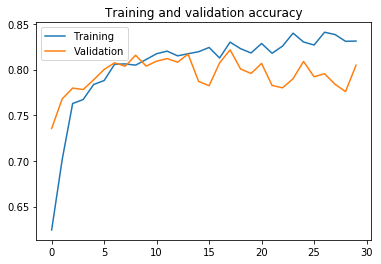

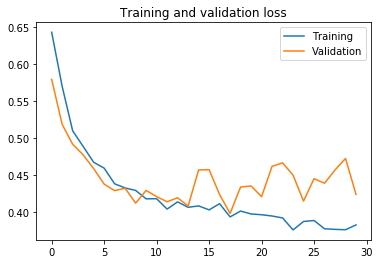

In [0]:
plot_training(history)

In [0]:
K.clear_session()

## Finding the right layer

Selecting Inceptionv3 up till mixed0
Last layer output shape:  (None, 10, 10, 256)
Training for variation: inception-till-mixed0.h5
Epoch 1/30
200/200 [==============================] - 20s 101ms/step - loss: 0.6255 - acc: 0.6585 - val_loss: 0.4939 - val_acc: 0.7768
Epoch 2/30
200/200 [==============================] - 18s 88ms/step - loss: 0.5373 - acc: 0.7322 - val_loss: 0.4536 - val_acc: 0.7922
Epoch 3/30
200/200 [==============================] - 20s 99ms/step - loss: 0.5011 - acc: 0.7640 - val_loss: 0.4325 - val_acc: 0.8122
Epoch 4/30
200/200 [==============================] - 19s 96ms/step - loss: 0.4685 - acc: 0.7850 - val_loss: 0.4218 - val_acc: 0.8156
Epoch 5/30
200/200 [==============================] - 17s 86ms/step - loss: 0.4665 - acc: 0.7878 - val_loss: 0.4136 - val_acc: 0.8204
Epoch 6/30
200/200 [==============================] - 17s 85ms/step - loss: 0.4466 - acc: 0.8027 - val_loss: 0.4206 - val_acc: 0.8088
Epoch 7/30
200/200 [==============================] - 18s 88ms/

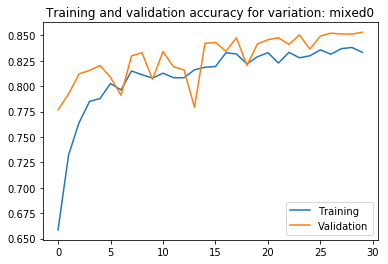

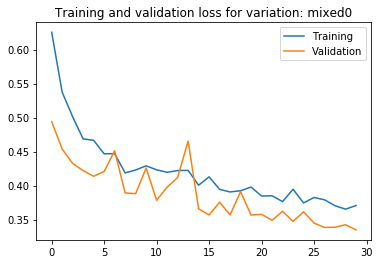

Selecting Inceptionv3 up till mixed1
Last layer output shape:  (None, 10, 10, 288)
Training for variation: inception-till-mixed1.h5
Epoch 1/30
200/200 [==============================] - 21s 103ms/step - loss: 0.5994 - acc: 0.6755 - val_loss: 0.5394 - val_acc: 0.7242
Epoch 2/30
200/200 [==============================] - 17s 85ms/step - loss: 0.5125 - acc: 0.7532 - val_loss: 0.4771 - val_acc: 0.7661
Epoch 3/30
200/200 [==============================] - 17s 85ms/step - loss: 0.4850 - acc: 0.7695 - val_loss: 0.4327 - val_acc: 0.8119
Epoch 4/30
200/200 [==============================] - 17s 87ms/step - loss: 0.4652 - acc: 0.7827 - val_loss: 0.4947 - val_acc: 0.7727
Epoch 5/30
200/200 [==============================] - 17s 86ms/step - loss: 0.4507 - acc: 0.7980 - val_loss: 0.4034 - val_acc: 0.8189
Epoch 6/30
200/200 [==============================] - 18s 88ms/step - loss: 0.4425 - acc: 0.7968 - val_loss: 0.4107 - val_acc: 0.8188
Epoch 7/30
200/200 [==============================] - 18s 88ms/

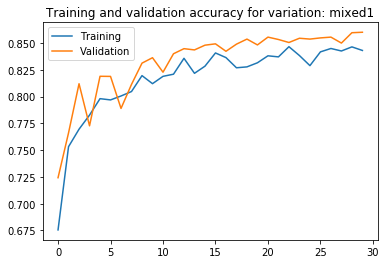

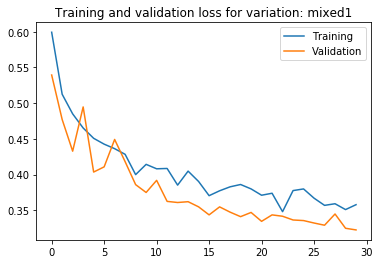

Selecting Inceptionv3 up till mixed2
Last layer output shape:  (None, 10, 10, 288)
Training for variation: inception-till-mixed2.h5
Epoch 1/30
200/200 [==============================] - 22s 110ms/step - loss: 0.6137 - acc: 0.6615 - val_loss: 0.5004 - val_acc: 0.7810
Epoch 2/30
200/200 [==============================] - 18s 89ms/step - loss: 0.5067 - acc: 0.7565 - val_loss: 0.4547 - val_acc: 0.7934
Epoch 3/30
200/200 [==============================] - 18s 91ms/step - loss: 0.4670 - acc: 0.7850 - val_loss: 0.4518 - val_acc: 0.7981
Epoch 4/30
200/200 [==============================] - 18s 91ms/step - loss: 0.4422 - acc: 0.8010 - val_loss: 0.3965 - val_acc: 0.8266
Epoch 5/30
200/200 [==============================] - 18s 92ms/step - loss: 0.4334 - acc: 0.8057 - val_loss: 0.4108 - val_acc: 0.8173
Epoch 6/30
200/200 [==============================] - 18s 92ms/step - loss: 0.4232 - acc: 0.8155 - val_loss: 0.4012 - val_acc: 0.8239
Epoch 7/30
200/200 [==============================] - 18s 92ms/

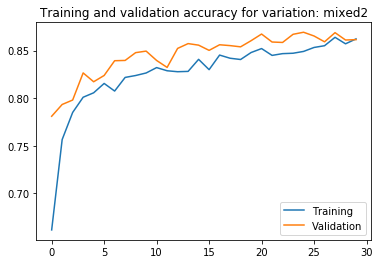

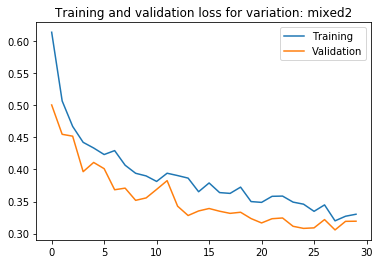

Selecting Inceptionv3 up till mixed3
Last layer output shape:  (None, 4, 4, 768)
Training for variation: inception-till-mixed3.h5
Epoch 1/30
200/200 [==============================] - 22s 112ms/step - loss: 0.6505 - acc: 0.6142 - val_loss: 0.5408 - val_acc: 0.7563
Epoch 2/30
200/200 [==============================] - 19s 93ms/step - loss: 0.5499 - acc: 0.7200 - val_loss: 0.4795 - val_acc: 0.7842
Epoch 3/30
200/200 [==============================] - 18s 92ms/step - loss: 0.4898 - acc: 0.7703 - val_loss: 0.4427 - val_acc: 0.8052
Epoch 4/30
200/200 [==============================] - 19s 93ms/step - loss: 0.4573 - acc: 0.7958 - val_loss: 0.4093 - val_acc: 0.8243
Epoch 5/30
200/200 [==============================] - 18s 92ms/step - loss: 0.4335 - acc: 0.8043 - val_loss: 0.3946 - val_acc: 0.8279
Epoch 6/30
200/200 [==============================] - 19s 94ms/step - loss: 0.4241 - acc: 0.8055 - val_loss: 0.3870 - val_acc: 0.8305
Epoch 7/30
200/200 [==============================] - 19s 94ms/st

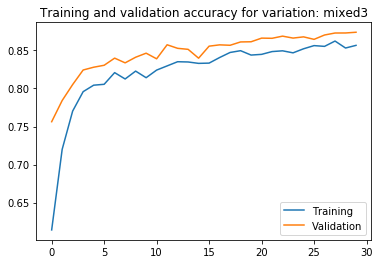

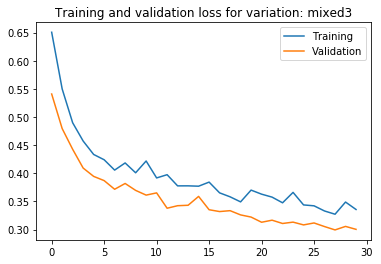

Selecting Inceptionv3 up till mixed4
Last layer output shape:  (None, 4, 4, 768)
Training for variation: inception-till-mixed4.h5
Epoch 1/30
200/200 [==============================] - 26s 128ms/step - loss: 0.6393 - acc: 0.6257 - val_loss: 0.5597 - val_acc: 0.7426
Epoch 2/30
200/200 [==============================] - 21s 104ms/step - loss: 0.5459 - acc: 0.7257 - val_loss: 0.4807 - val_acc: 0.7974
Epoch 3/30
200/200 [==============================] - 20s 102ms/step - loss: 0.4952 - acc: 0.7730 - val_loss: 0.4398 - val_acc: 0.8143
Epoch 4/30
200/200 [==============================] - 20s 102ms/step - loss: 0.4642 - acc: 0.7897 - val_loss: 0.4088 - val_acc: 0.8261
Epoch 5/30
200/200 [==============================] - 21s 103ms/step - loss: 0.4198 - acc: 0.8138 - val_loss: 0.4078 - val_acc: 0.8246
Epoch 6/30
200/200 [==============================] - 21s 103ms/step - loss: 0.4212 - acc: 0.8083 - val_loss: 0.3740 - val_acc: 0.8366
Epoch 7/30
200/200 [==============================] - 21s 10

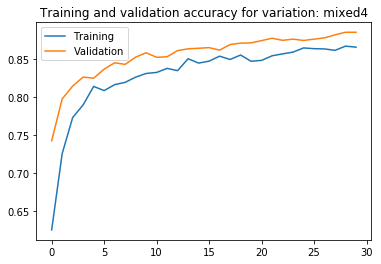

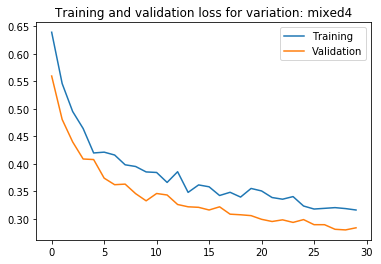

Selecting Inceptionv3 up till mixed5
Last layer output shape:  (None, 4, 4, 768)
Training for variation: inception-till-mixed5.h5
Epoch 1/30
200/200 [==============================] - 29s 146ms/step - loss: 0.6464 - acc: 0.6143 - val_loss: 0.5838 - val_acc: 0.7147
Epoch 2/30
200/200 [==============================] - 23s 115ms/step - loss: 0.5696 - acc: 0.7072 - val_loss: 0.5139 - val_acc: 0.7837
Epoch 3/30
200/200 [==============================] - 23s 116ms/step - loss: 0.5071 - acc: 0.7563 - val_loss: 0.4569 - val_acc: 0.8051
Epoch 4/30
200/200 [==============================] - 23s 116ms/step - loss: 0.4876 - acc: 0.7773 - val_loss: 0.4228 - val_acc: 0.8152
Epoch 5/30
200/200 [==============================] - 23s 116ms/step - loss: 0.4491 - acc: 0.7993 - val_loss: 0.3966 - val_acc: 0.8267
Epoch 6/30
200/200 [==============================] - 23s 116ms/step - loss: 0.4276 - acc: 0.8073 - val_loss: 0.3751 - val_acc: 0.8373
Epoch 7/30
200/200 [==============================] - 23s 11

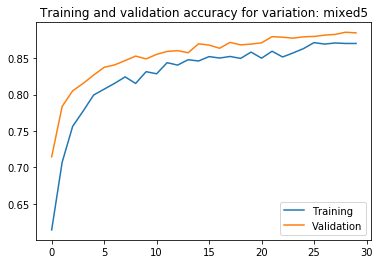

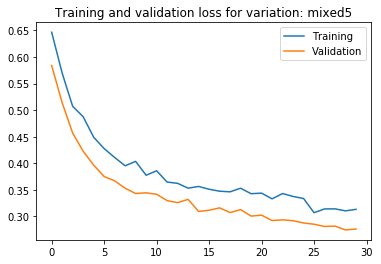

Selecting Inceptionv3 up till mixed6
Last layer output shape:  (None, 4, 4, 768)
Training for variation: inception-till-mixed6.h5
Epoch 1/30
200/200 [==============================] - 32s 161ms/step - loss: 0.6557 - acc: 0.6092 - val_loss: 0.6115 - val_acc: 0.6751
Epoch 2/30
200/200 [==============================] - 26s 128ms/step - loss: 0.6053 - acc: 0.6650 - val_loss: 0.5595 - val_acc: 0.7342
Epoch 3/30
200/200 [==============================] - 25s 126ms/step - loss: 0.5483 - acc: 0.7262 - val_loss: 0.4998 - val_acc: 0.7798
Epoch 4/30
200/200 [==============================] - 25s 126ms/step - loss: 0.5118 - acc: 0.7648 - val_loss: 0.4548 - val_acc: 0.8028
Epoch 5/30
200/200 [==============================] - 25s 126ms/step - loss: 0.4682 - acc: 0.7933 - val_loss: 0.4165 - val_acc: 0.8220
Epoch 6/30
200/200 [==============================] - 25s 127ms/step - loss: 0.4411 - acc: 0.8002 - val_loss: 0.4025 - val_acc: 0.8259
Epoch 7/30
200/200 [==============================] - 26s 12

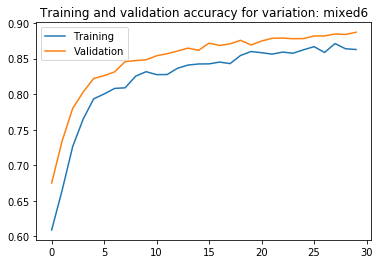

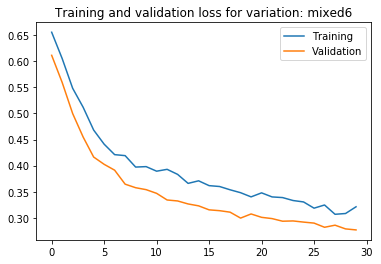

Selecting Inceptionv3 up till mixed7
Last layer output shape:  (None, 4, 4, 768)
Training for variation: inception-till-mixed7.h5
Epoch 1/30
200/200 [==============================] - 36s 180ms/step - loss: 0.6801 - acc: 0.5533 - val_loss: 0.6588 - val_acc: 0.5986
Epoch 2/30
200/200 [==============================] - 28s 138ms/step - loss: 0.6581 - acc: 0.5967 - val_loss: 0.6501 - val_acc: 0.6138
Epoch 3/30
200/200 [==============================] - 28s 138ms/step - loss: 0.6420 - acc: 0.6135 - val_loss: 0.6388 - val_acc: 0.6087
Epoch 4/30
200/200 [==============================] - 28s 138ms/step - loss: 0.6332 - acc: 0.6329 - val_loss: 0.6180 - val_acc: 0.6493
Epoch 5/30
200/200 [==============================] - 28s 139ms/step - loss: 0.6122 - acc: 0.6677 - val_loss: 0.5907 - val_acc: 0.6916
Epoch 6/30
200/200 [==============================] - 27s 137ms/step - loss: 0.5818 - acc: 0.7103 - val_loss: 0.5456 - val_acc: 0.7541
Epoch 7/30
200/200 [==============================] - 28s 13

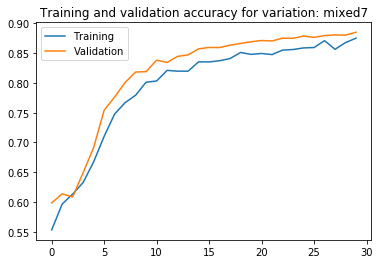

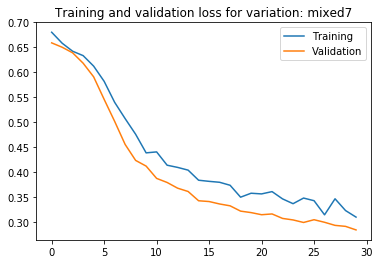

Selecting Inceptionv3 up till mixed8
Last layer output shape:  (None, 1, 1, 1280)
Training for variation: inception-till-mixed8.h5
Epoch 1/30
200/200 [==============================] - 38s 188ms/step - loss: 0.6896 - acc: 0.5268 - val_loss: 0.6656 - val_acc: 0.5957
Epoch 2/30
200/200 [==============================] - 29s 144ms/step - loss: 0.6661 - acc: 0.5777 - val_loss: 0.6484 - val_acc: 0.6194
Epoch 3/30
200/200 [==============================] - 29s 144ms/step - loss: 0.6533 - acc: 0.6043 - val_loss: 0.6215 - val_acc: 0.6566
Epoch 4/30
200/200 [==============================] - 30s 148ms/step - loss: 0.6244 - acc: 0.6422 - val_loss: 0.5964 - val_acc: 0.6878
Epoch 5/30
200/200 [==============================] - 29s 144ms/step - loss: 0.5965 - acc: 0.6710 - val_loss: 0.5711 - val_acc: 0.7209
Epoch 6/30
200/200 [==============================] - 29s 143ms/step - loss: 0.5874 - acc: 0.6895 - val_loss: 0.5490 - val_acc: 0.7391
Epoch 7/30
200/200 [==============================] - 29s 1

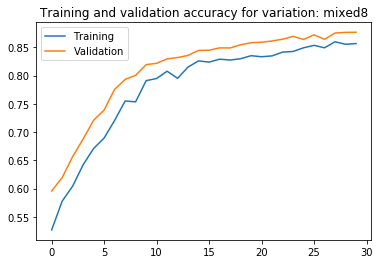

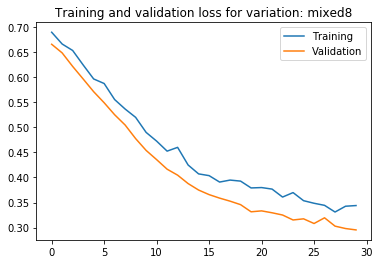

Selecting Inceptionv3 up till mixed9
Last layer output shape:  (None, 1, 1, 2048)
Training for variation: inception-till-mixed9.h5
Epoch 1/30
200/200 [==============================] - 42s 210ms/step - loss: 0.6771 - acc: 0.5567 - val_loss: 0.6717 - val_acc: 0.5983
Epoch 2/30
200/200 [==============================] - 32s 160ms/step - loss: 0.6705 - acc: 0.5740 - val_loss: 0.6678 - val_acc: 0.5926
Epoch 3/30
200/200 [==============================] - 32s 162ms/step - loss: 0.6617 - acc: 0.5932 - val_loss: 0.6543 - val_acc: 0.5939
Epoch 4/30
200/200 [==============================] - 34s 168ms/step - loss: 0.6480 - acc: 0.6025 - val_loss: 0.6473 - val_acc: 0.5955
Epoch 5/30
200/200 [==============================] - 32s 158ms/step - loss: 0.6386 - acc: 0.6068 - val_loss: 0.6371 - val_acc: 0.5931
Epoch 6/30
200/200 [==============================] - 32s 158ms/step - loss: 0.6292 - acc: 0.5987 - val_loss: 0.6215 - val_acc: 0.5981
Epoch 7/30
200/200 [==============================] - 32s 1

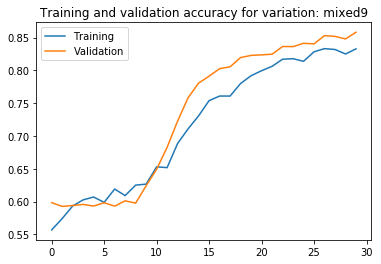

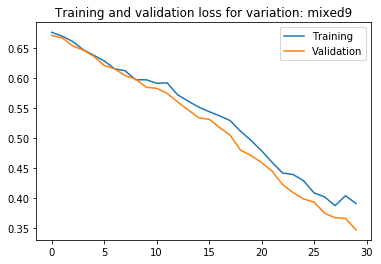

In [0]:
last_layers = ['mixed' + str(i) for i in np.arange(0,10)]
model_variations = dict()
training_histories = []
training_metrics = []


for layer_name in last_layers:
  # Load the pretrained model
  pre_trained_model = InceptionV3(input_shape=(100, 100, 3), include_top=False, weights=None)
  pre_trained_model.load_weights(local_weights_file)
  # Extract output from the last layer to be used
  
  print("Selecting Inceptionv3 up till " + layer_name)
  last_layer = pre_trained_model.get_layer(layer_name)
  print('Last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output

  # Place new top layers on the model
  x = layers.Flatten()(last_output)

  x = layers.Dense(256, activation='relu')(x)

  x = layers.Dense(256, activation='relu')(x)

  x = layers.Dropout(0.4)(x)

  predictions = layers.Dense(1, activation='sigmoid')(x)

  # Initialize the model architecture
  inception_model = Model(pre_trained_model.input, predictions)

  # Compile the model
  learning_rate = 0.001
  steps_per_epoch = 200
  epochs = 30
  validation_steps = 600
  optimizer=SGD(lr=learning_rate)
  inception_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])

  # Train the model on the dataset using the generator
  print("Training for variation: " + "inception-till-" + layer_name +".h5")
  history = inception_model.fit_generator(
      generator=train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      verbose=1,
      validation_data=val_generator,
      validation_steps=validation_steps
  )

  # Save the training history to view it later
  training_histories.append(history)

  # Get the metrics to document experimentation
  metrics = get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    verbose=False,
    add_table_header=False,
    frozen_layer=layer_name)
  training_metrics.append(metrics)

  # Plot the graphs of the training 
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  plt.figure()

  plt.plot(epochs, acc, label="Training")
  plt.plot(epochs, val_acc, label="Validation")
  plt.title('Training and validation accuracy for variation: ' + layer_name)
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label="Training")
  plt.plot(epochs, val_loss, label="Validation")
  plt.title('Training and validation loss for variation: ' + layer_name)
  plt.legend()
  plt.show()

  # Save the model and clear the clutter
  inception_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models/inception-variations', 'inception-till-' + layer_name +'.h5'))
  del inception_model
  del pre_trained_model
  K.clear_session()


In [0]:
for metrics_version in training_metrics:
  print(metrics_version, end="")

> mixed0 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3706$ | | $Loss_{val} = 0.3347$ |  |$Accuracy_{train} = 0.8333$ | |  $Accuracy_{val} = 0.8532$
> mixed1 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3577$ | | $Loss_{val} = 0.3223$ |  |$Accuracy_{train} = 0.8430$ | |  $Accuracy_{val} = 0.8600$
> mixed2 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3302$ | | $Loss_{val} = 0.3193$ |  |$Accuracy_{train} = 0.8623$ | |  $Accuracy_{val} = 0.8616$
> mixed3 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3358$ | | $Loss_{val} = 0.3005$ |  |$Accuracy_{train} = 0.8567$ | |  $Accuracy_{val} = 0.8739$
> mixed4 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3161$ | | $Loss_{val} = 0.2837$ |  |$Accuracy_{train} = 0.8653$ | |  $Accuracy_{val} = 0.8849$
> mixed5 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3134$ | | $Loss_{val} = 0.2764$ |  |$Accuracy_{train} = 0.8700$

## Results
>Last Layer | Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | --- | ---
> mixed0 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3706$ | | $Loss_{val} = 0.3347$ |  |$Accuracy_{train} = 0.8333$ | |  $Accuracy_{val} = 0.8532$
> mixed1 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3577$ | | $Loss_{val} = 0.3223$ |  |$Accuracy_{train} = 0.8430$ | |  $Accuracy_{val} = 0.8600$
> mixed2 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3302$ | | $Loss_{val} = 0.3193$ |  |$Accuracy_{train} = 0.8623$ | |  $Accuracy_{val} = 0.8616$
> mixed3 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3358$ | | $Loss_{val} = 0.3005$ |  |$Accuracy_{train} = 0.8567$ | |  $Accuracy_{val} = 0.8739$
> mixed4 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3161$ | | $Loss_{val} = 0.2837$ |  |$Accuracy_{train} = 0.8653$ | |  $Accuracy_{val} = 0.8849$
> mixed5 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3134$ | | $Loss_{val} = 0.2764$ |  |$Accuracy_{train} = 0.8700$ | |  $Accuracy_{val} = 0.8845$
> mixed6 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3211$ | | $Loss_{val} = 0.2768$ |  |$Accuracy_{train} = 0.8627$ | |  $Accuracy_{val} = 0.8869$
> mixed7 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3098$ | | $Loss_{val} = 0.2842$ |  |$Accuracy_{train} = 0.8750$ | |  $Accuracy_{val} = 0.8850$
> mixed8 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3440$ | | $Loss_{val} = 0.2954$ |  |$Accuracy_{train} = 0.8567$ | |  $Accuracy_{val} = 0.8767$
> mixed9 | 70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3905$ | | $Loss_{val} = 0.3464$ |  |$Accuracy_{train} = 0.8328$ | |  $Accuracy_{val} = 0.8582$

# Inception-V3 (Retraining complete architecture)

## Setting up the model architecture

In [0]:
from keras.applications.inception_v3 import InceptionV3

predefined_model = InceptionV3(
    input_shape=(100,100,3),
    include_top=True,
    weights=None,
    classes=1)

## Fitting model on the data

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.3498$ | | $Loss_{val} = 0.4528$ |  |$Accuracy_{train} = 0.8498$ | |  $Accuracy_{val} = 0.7849$
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3741$ | | $Loss_{val} = 9.5304$ |  |$Accuracy_{train} = 0.4120$ | |  $Accuracy_{val} = 0.4022$

Changing model initization using the API:

```python
predefined_model = InceptionV3(
    input_shape=(100, 100, 3),
    include_top=False,
    weights=None)
```
TO:
```python
predefined_model = InceptionV3(
    input_shape=(100,100,3),
    include_top=True,
    weights=None,
    classes=1)
```

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### Training results

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))

In [0]:
predefined_model.summary()

In [0]:
del predefined_model

# VGG-Net (Roughly copied architecture)

## Creating VGG-Net's architecture

In [0]:
img_input = layers.Input(shape=(100, 100, 3))

x = layers.Conv2D(64, 2, activation='relu')(img_input)
x = layers.Conv2D(64, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 2, activation='relu')(x)
x = layers.Conv2D(128, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(256, 2, activation='relu')(x)
x = layers.Conv2D(256, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.Conv2D(512, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)

output = layers.Dense(1, activation='sigmoid')(x)

vgg_model = Model(img_input, output)

vgg_model.summary()

## Fitting the data on the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 30 | 200 | 600 | SGD | 0.001000 
>$Loss_{train} =  0.6742$ | | $Loss_{val} = 0.6731$ |  |$Accuracy_{train} = 0.5970$ | |  $Accuracy_{val} = 0.5998$

In [0]:
learning_rate = 0.001
steps_per_epoch = 200
epochs = 30
validation_steps = 600
optimizer=SGD(lr=learning_rate)

In [0]:
vgg_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = vgg_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

#VGG16 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.vgg16 import VGG16

predefined_model = VGG16(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.5619$ | | $Loss_{val} = 9.4645$ |  |$Accuracy_{train} = 0.4002$ | |  $Accuracy_{val} = 0.4063$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### Training results

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#VGG19 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.vgg19 import VGG19

predefined_model = VGG19(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6646$ | | $Loss_{val} = 9.5123$ |  |$Accuracy_{train} = 0.3938$ | |  $Accuracy_{val} = 0.4033$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6646$ | | $Loss_{val} = 9.5123$ |  |$Accuracy_{train} = 0.3938$ | |  $Accuracy_{val} = 0.4033$


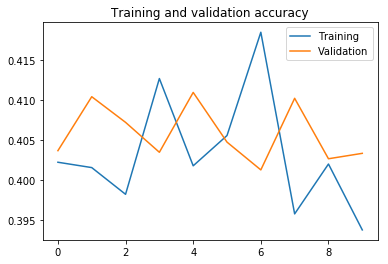

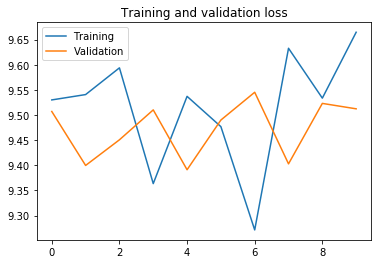

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

NameError: ignored

#ResNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.resnet import ResNet152

predefined_model = ResNet152(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7249$ | | $Loss_{val} = 9.4708$ |  |$Accuracy_{train} = 0.3900$ | |  $Accuracy_{val} = 0.4059$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 300s 2s/step - loss: 9.5690 - acc: 0.3998 - val_loss: 9.4506 - val_acc: 0.4072
Epoch 2/10
150/150 [==============================] - 226s 2s/step - loss: 9.5371 - acc: 0.4018 - val_loss: 9.4305 - val_acc: 0.4085
Epoch 3/10
150/150 [==============================] - 227s 2s/step - loss: 9.5052 - acc: 0.4038 - val_loss: 9.5006 - val_acc: 0.4041
Epoch 4/10
150/150 [==============================] - 228s 2s/step - loss: 9.4769 - acc: 0.4056 - val_loss: 9.4666 - val_acc: 0.4062
Epoch 5/10
150/150 [==============================] - 228s 2s/step - loss: 9.4981 - acc: 0.4042 - val_loss: 9.5231 - val_acc: 0.4027
Epoch 6/10
150/150 [==============================] - 230s 2s/step - loss: 9.3989 - acc: 0.4104 - val_loss: 9.4868 - val_acc: 0.4049
Epoch 7/10
150/150 [==============================] - 227s 2s/step - loss: 9.3600 - acc: 0.4129 - val_loss: 9.4974 - val_acc: 0.4043
Epoch 8/10
150/150 [==============================] - 230s 2s/step - 

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7249$ | | $Loss_{val} = 9.4708$ |  |$Accuracy_{train} = 0.3900$ | |  $Accuracy_{val} = 0.4059$


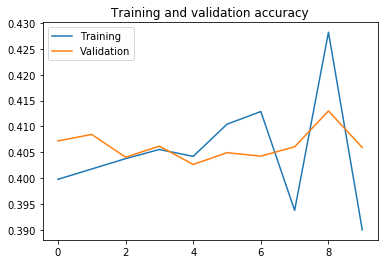

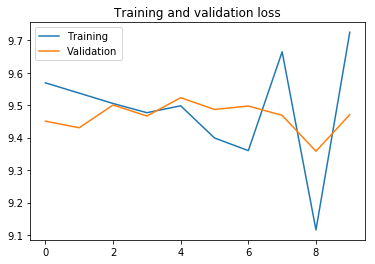

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#InceptionResNetV2 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

predefined_model = InceptionResNetV2(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 49, 49, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 49, 49, 32)   96          conv2d_208[0][0]                 
__________________________________________________________________________________________________
activation_392 (Activation)     (None, 49, 49, 32)   0           batch_normalization_208[0][0]    
________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7071$ | | $Loss_{val} = 9.4985$ |  |$Accuracy_{train} = 0.3911$ | |  $Accuracy_{val} = 0.4042$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 197s 1s/step - loss: 9.4839 - acc: 0.4051 - val_loss: 9.4570 - val_acc: 0.4068
Epoch 2/10
150/150 [==============================] - 140s 935ms/step - loss: 9.5548 - acc: 0.4007 - val_loss: 9.4581 - val_acc: 0.4067
Epoch 3/10
150/150 [==============================] - 140s 933ms/step - loss: 9.5052 - acc: 0.4038 - val_loss: 9.5229 - val_acc: 0.4027
Epoch 4/10
150/150 [==============================] - 140s 931ms/step - loss: 9.5158 - acc: 0.4031 - val_loss: 9.4379 - val_acc: 0.4080
Epoch 5/10
150/150 [==============================] - 140s 933ms/step - loss: 9.5123 - acc: 0.4033 - val_loss: 9.4688 - val_acc: 0.4061
Epoch 6/10
150/150 [==============================] - 140s 931ms/step - loss: 9.3600 - acc: 0.4129 - val_loss: 9.4049 - val_acc: 0.4101
Epoch 7/10
150/150 [==============================] - 140s 932ms/step - loss: 9.5371 - acc: 0.4018 - val_loss: 9.4326 - val_acc: 0.4083
Epoch 8/10
150/150 [==============================]

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.7071$ | | $Loss_{val} = 9.4985$ |  |$Accuracy_{train} = 0.3911$ | |  $Accuracy_{val} = 0.4042$


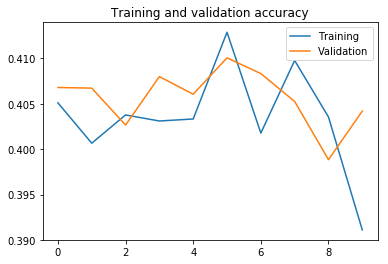

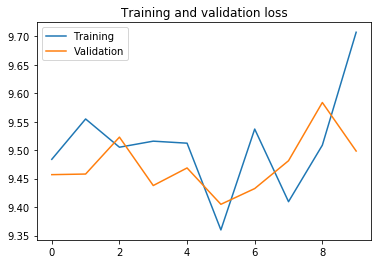

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#MobileNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.mobilenet import MobileNet

predefined_model = MobileNet(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "mobilenet_1.00_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32) 

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.1899$ | | $Loss_{val} = 9.3954$ |  |$Accuracy_{train} = 0.4236$ | |  $Accuracy_{val} = 0.4107$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 69s 463ms/step - loss: 9.2997 - acc: 0.4167 - val_loss: 9.5463 - val_acc: 0.4012
Epoch 2/10
150/150 [==============================] - 33s 218ms/step - loss: 9.3529 - acc: 0.4133 - val_loss: 9.4411 - val_acc: 0.4078
Epoch 3/10
150/150 [==============================] - 32s 216ms/step - loss: 9.4698 - acc: 0.4060 - val_loss: 9.4687 - val_acc: 0.4061
Epoch 4/10
150/150 [==============================] - 43s 289ms/step - loss: 9.6823 - acc: 0.3927 - val_loss: 9.3848 - val_acc: 0.4113
Epoch 5/10
150/150 [==============================] - 37s 250ms/step - loss: 9.4875 - acc: 0.4049 - val_loss: 9.5060 - val_acc: 0.4037
Epoch 6/10
150/150 [==============================] - 33s 219ms/step - loss: 9.5158 - acc: 0.4031 - val_loss: 9.4560 - val_acc: 0.4069
Epoch 7/10
150/150 [==============================] - 34s 227ms/step - loss: 9.4769 - acc: 0.4056 - val_loss: 9.5420 - val_acc: 0.4015
Epoch 8/10
150/150 [==============================] - 3

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.1899$ | | $Loss_{val} = 9.3954$ |  |$Accuracy_{train} = 0.4236$ | |  $Accuracy_{val} = 0.4107$


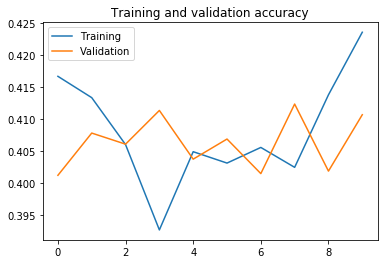

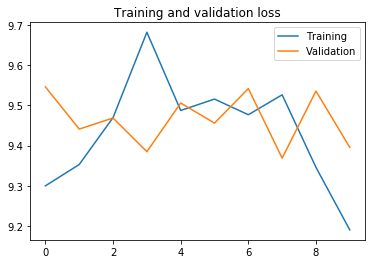

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#MobileNetV2 (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.mobilenet_v2 import MobileNetV2

predefined_model = MobileNetV2(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "mobilenetv2_1.00_100"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 101, 101, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 50, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 50, 50, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.4556$ | | $Loss_{val} = 9.4145$ |  |$Accuracy_{train} = 0.4069$ | |  $Accuracy_{val} = 0.4095$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 82s 544ms/step - loss: 9.4343 - acc: 0.4082 - val_loss: 9.4772 - val_acc: 0.4055
Epoch 2/10
150/150 [==============================] - 42s 283ms/step - loss: 9.4414 - acc: 0.4078 - val_loss: 9.4071 - val_acc: 0.4099
Epoch 3/10
150/150 [==============================] - 45s 297ms/step - loss: 9.6505 - acc: 0.3947 - val_loss: 9.4878 - val_acc: 0.4049
Epoch 4/10
150/150 [==============================] - 45s 297ms/step - loss: 9.4804 - acc: 0.4053 - val_loss: 9.4921 - val_acc: 0.4046
Epoch 5/10
150/150 [==============================] - 41s 274ms/step - loss: 9.5619 - acc: 0.4002 - val_loss: 9.4209 - val_acc: 0.4091
Epoch 6/10
150/150 [==============================] - 39s 258ms/step - loss: 9.5158 - acc: 0.4031 - val_loss: 9.4262 - val_acc: 0.4087
Epoch 7/10
150/150 [==============================] - 40s 267ms/step - loss: 9.4556 - acc: 0.4069 - val_loss: 9.4315 - val_acc: 0.4084
Epoch 8/10
150/150 [==============================] - 4

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.4556$ | | $Loss_{val} = 9.4145$ |  |$Accuracy_{train} = 0.4069$ | |  $Accuracy_{val} = 0.4095$


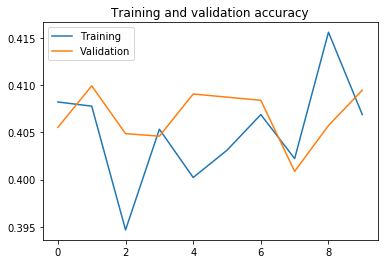

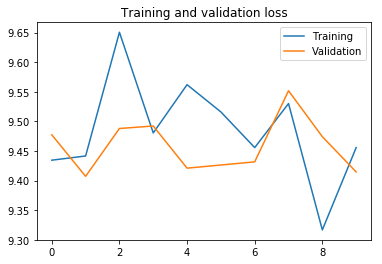

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#DenseNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.densenet import DenseNet201

predefined_model = DenseNet201(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 106, 106, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6398$ | | $Loss_{val} = 9.5612$ |  |$Accuracy_{train} = 0.3953$ | |  $Accuracy_{val} = 0.4003$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 212s 1s/step - loss: 9.5513 - acc: 0.4009 - val_loss: 9.4358 - val_acc: 0.4081
Epoch 2/10
150/150 [==============================] - 139s 926ms/step - loss: 9.4627 - acc: 0.4064 - val_loss: 9.3401 - val_acc: 0.4141
Epoch 3/10
150/150 [==============================] - 139s 927ms/step - loss: 9.4769 - acc: 0.4056 - val_loss: 9.5038 - val_acc: 0.4039
Epoch 4/10
150/150 [==============================] - 139s 929ms/step - loss: 9.5229 - acc: 0.4027 - val_loss: 9.5824 - val_acc: 0.3989
Epoch 5/10
150/150 [==============================] - 140s 932ms/step - loss: 9.2395 - acc: 0.4204 - val_loss: 9.4933 - val_acc: 0.4045
Epoch 6/10
150/150 [==============================] - 139s 927ms/step - loss: 9.5548 - acc: 0.4007 - val_loss: 9.4602 - val_acc: 0.4066
Epoch 7/10
150/150 [==============================] - 139s 928ms/step - loss: 9.6505 - acc: 0.3947 - val_loss: 9.4421 - val_acc: 0.4077
Epoch 8/10
150/150 [==============================]

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.6398$ | | $Loss_{val} = 9.5612$ |  |$Accuracy_{train} = 0.3953$ | |  $Accuracy_{val} = 0.4003$


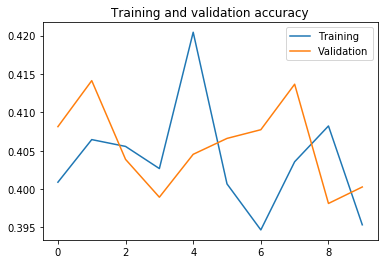

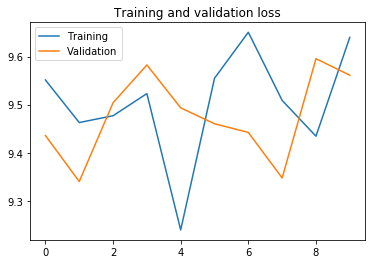

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#NASNet (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.nasnet import NASNetMobile

predefined_model = NASNetMobile(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 49, 49, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 49, 49, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_595 (Activation)     (None, 49, 49, 32)   0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3918$ | | $Loss_{val} = 9.4326$ |  |$Accuracy_{train} = 0.4109$ | |  $Accuracy_{val} = 0.4083$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 172s 1s/step - loss: 9.5371 - acc: 0.4018 - val_loss: 9.5410 - val_acc: 0.4015
Epoch 2/10
150/150 [==============================] - 93s 621ms/step - loss: 9.3281 - acc: 0.4149 - val_loss: 9.3826 - val_acc: 0.4115
Epoch 3/10
150/150 [==============================] - 94s 630ms/step - loss: 9.4166 - acc: 0.4093 - val_loss: 9.4847 - val_acc: 0.4051
Epoch 4/10
150/150 [==============================] - 100s 664ms/step - loss: 9.4343 - acc: 0.4082 - val_loss: 9.4219 - val_acc: 0.4090
Epoch 5/10
150/150 [==============================] - 94s 627ms/step - loss: 9.3777 - acc: 0.4118 - val_loss: 9.5646 - val_acc: 0.4001
Epoch 6/10
150/150 [==============================] - 92s 616ms/step - loss: 9.4450 - acc: 0.4076 - val_loss: 9.4581 - val_acc: 0.4067
Epoch 7/10
150/150 [==============================] - 96s 639ms/step - loss: 9.5265 - acc: 0.4024 - val_loss: 9.5293 - val_acc: 0.4023
Epoch 8/10
150/150 [==============================] - 98

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3918$ | | $Loss_{val} = 9.4326$ |  |$Accuracy_{train} = 0.4109$ | |  $Accuracy_{val} = 0.4083$


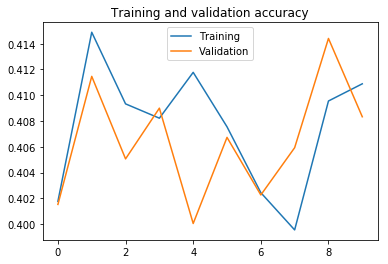

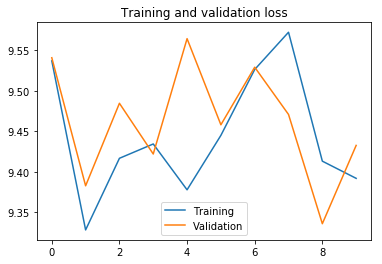

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model

#Xception (Retraining)

## Setting up the model architecture

In [0]:
from keras.applications.xception import Xception

predefined_model = Xception(
    input_shape=(100, 100, 3),
    weights=None,
    include_top=True,
    classes=1)
predefined_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_19[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Fitting the model

>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3245$ | | $Loss_{val} = 9.4177$ |  |$Accuracy_{train} = 0.4151$ | |  $Accuracy_{val} = 0.4093$

In [0]:
learning_rate = 0.001
steps_per_epoch = 150
epochs = 10
validation_steps = 500
optimizer=SGD(lr=learning_rate)

In [0]:
predefined_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])


history = predefined_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
150/150 [==============================] - 156s 1s/step - loss: 9.4733 - acc: 0.4058 - val_loss: 9.4623 - val_acc: 0.4065
Epoch 2/10
150/150 [==============================] - 99s 661ms/step - loss: 9.5477 - acc: 0.4011 - val_loss: 9.4772 - val_acc: 0.4055
Epoch 3/10
150/150 [==============================] - 98s 656ms/step - loss: 9.4131 - acc: 0.4096 - val_loss: 9.4900 - val_acc: 0.4047
Epoch 4/10
150/150 [==============================] - 99s 661ms/step - loss: 9.4591 - acc: 0.4067 - val_loss: 9.4932 - val_acc: 0.4045
Epoch 5/10
150/150 [==============================] - 100s 667ms/step - loss: 9.5583 - acc: 0.4004 - val_loss: 9.3975 - val_acc: 0.4105
Epoch 6/10
150/150 [==============================] - 99s 661ms/step - loss: 9.6292 - acc: 0.3960 - val_loss: 9.4602 - val_acc: 0.4066
Epoch 7/10
150/150 [==============================] - 99s 662ms/step - loss: 9.3529 - acc: 0.4133 - val_loss: 9.4804 - val_acc: 0.4053
Epoch 8/10
150/150 [==============================] - 94

### Training results

copy the following text to your notebook text block: 
>Split Size | Batch Size | Epochs | Steps Per Epoch | Validation Steps | Optimizer | Learning Rate
>--- | --- | --- | --- | --- | --- | ---
>70-30 | 30 | 10 | 150 | 500 | SGD | 0.001000 
>$Loss_{train} =  9.3245$ | | $Loss_{val} = 9.4177$ |  |$Accuracy_{train} = 0.4151$ | |  $Accuracy_{val} = 0.4093$


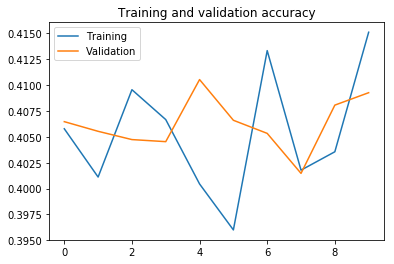

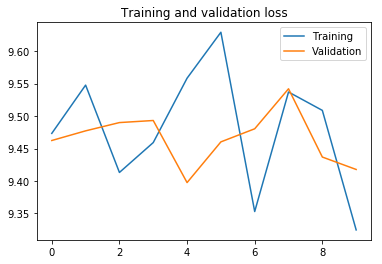

In [0]:
get_training_metrics(
    train_split_percentage=train_percentage,
    history=history,
    optimizer=optimizer,
    learning_rate=learning_rate,
    steps_per_epoch=steps_per_epoch,
    total_epochs=epochs,
    validation_steps=validation_steps,
    batch_size=batch_size,
    print_table_header=True)

plot_training(history)

### Saving the model

In [0]:
predefined_model.save(os.path.join('/content/drive/My Drive/Datasets/histopathologic-cancer-detection-models', 'retrained-' + predefined_model.name +'.h5'))
del predefined_model